# Solving Simply Supported Beam w/ Mesh & Beam Classes

This notebook ideally serves as a comprehensive guide going over the Mesh and Beam classes developed for Assignment 2 Part 1. These classes are used to construct and solve linear beam systems. This notebook will specifically go over a simple example that will show how to use this to solve any linear beam system.

The problem that we will be analyzing is a simply supported beam with a load directly at the center:

![Problem Diagram](figures/simple_simple_diagram.png)

We will simulate this problem by breaking the beam up into two halves connected at a node where the force is being applied. The two end-nodes will have fixed translational and free rotational boundary conditions while the center node will have free translational and fixed rotational boundary conditions. 

## Class Overview

There are two classes used to construct the truss system: ```Mesh``` and ```Beam```.

The ```Mesh``` class represents a mesh of nodes connected by elements. Each node has a set of degrees of freedom connected x with some action or force f. These nodes are then connected to each other via elements. These object describe how the x and f of each node relate to each other based on the following equation:

```math 
\left[\begin{matrix}\vec{f}_1 \\ \vec{f}_2\end{matrix}\right] = K \left[\begin{matrix}\vec{x}_1 \\ \vec{x}_2\end{matrix}\right] 
```

The Mesh class allows you to gather a bunch of these elements connected together into a single system which can be solved all at once. For our system, x will represent the translation and rotation of our nodes while f will represent the forces and moments in our system

In [1]:
from mesh import Mesh

The ```Beam``` class is used to specifically describe a beam element. The user can pass all the necessary parameters into creating a ```Beam``` object and it will have all the necessary built-in methods to be used with the ```Mesh``` class.

In [2]:
from beam import Beam

Finally, we need to install ```numpy``` since all of our vectors and matrices are stored and passed with ```ndarray```.

In [3]:
import numpy as np

The first thing we do is initialize a ```Mesh```. To do this, all we need to do is specify the number of DoFs at each node. For a beam problem, that number is 6 per node: 3 for each translational DoF and 3 for each rotational DoF.

In [4]:
mesh = Mesh(6)

Next we will define the geometry and loading of our system. This is done through adding nodes to the ```Mesh``` object we created. To start, we define the total force applied at the center node and the total length of the beam:

In [5]:
F = 1
L = 1

Nodes are added to a mesh using four inputs: An integer index starting at 0, the spatial position of the node, the boundary conditions at the node, and optionally any applied forces. 

The boundary condition formatting is as follows:

- If it is any defined number, it specifies the fixed displacement along that DoF
- If it is assigned as ```np.nan```, then it is free and the condition is that the total reaction at the node is zero.

In [6]:
# We begin applying nodes.

# If no applied forces are given, it is assumed to be zero. Displacement format follows [x, y, z, rotx, roty, rotz]
mesh.add_node(0, np.array([0, 0, 0]), np.array([0, 0, 0, np.nan, np.nan, np.nan]))
# Center node. Applied force format follow [Fx, Fy, Fz, Mx, My, Mz]
mesh.add_node(1, np.array([L/2, 0, 0]), np.array([np.nan, np.nan, np.nan, 0, 0, 0]), bf=np.array([0, -F, 0, 0, 0, 0]))
# End node. Same as the first node just at a different position.
mesh.add_node(2, np.array([L, 0, 0]), np.array([0, 0, 0, np.nan, np.nan, np.nan]))

We now need to define our beams. Each beam requires the following parameters:

- Elastic Modulus E
- Constant Cross-Sectional Area A
- Cartestian Second Moments of Area Iy and Iz
- Polar Second Moment of Area J
- Poisson Ratio v

In [7]:
E = 1
A = 1
Iy = 1
Iz = 1
J = 1
v = 0.2

With the constants, we can passed it into the ```Beam``` constructor along with an orientation vector. This is just any vector in the xy-plane and is used to determine the orientation of the beam. One this is done, it can be added to the mesh using the ```add_element``` method.

In [8]:
beam = Beam(E=E, A=A, Iy=Iy, Iz=Iz, J=J, v=v, y=np.array([0, 1, 0]))
# Add the connection to the mesh as a beam. We specify the nodes based on the identifier
mesh.add_element(beam, 0, 1)
mesh.add_element(beam, 1, 2)

Once this is done, we can solve our system to get our displacements and reactions.

In [9]:
x, f = mesh.solve()

print(x)
print(f)

[ 0.          0.          0.          0.          0.         -0.0625
  0.         -0.02083333  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.0625    ]
[0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]


This problem has an explicit solution. If we compare them, we can see that the ```Mesh``` and ```Beam``` classes are able to successfully solve the system. 

In [10]:
tzmax = F*L**2/(16*E*Iz)
ymax = -F*L**3/(48*E*Iz)

d = np.array([
    0, 0, 0,
    0, 0, -tzmax,
    0, ymax, 0,
    0, 0, 0,
    0, 0, 0,
    0, 0, tzmax
])
r = np.array([
    0, F/2, 0,
    0, 0, 0,
    0, 0, 0,
    0, 0, 0,
    0, F/2, 0,
    0, 0, 0
])

print(np.linalg.norm(d - x))
print(np.linalg.norm(r - f))

0.0
0.0


# Example 1

In [11]:
mesh = Mesh(6)

F = np.array([0.1, 0.05, -0.07])
M = np.array([0.05, -0.1, 0.25])
bf1 = np.append(F, M)

mesh.add_node(0, pos=np.array([0, 0, 10]), bc=np.zeros(6))
mesh.add_node(1, pos=np.array([15, 0, 10]), bc=np.full(6, np.nan), bf=bf1)
mesh.add_node(2, pos=np.array([15, 0, 0]), bc=np.array([0, 0, 0, np.nan, np.nan, np.nan]))

In [12]:
b = 0.5
h = 1
A = b*h
Iz = h*b**3/12
Iy = b*h**3/12
J = 0.02861
E = 1000
v = 0.3

beam1 = Beam(E=E, A=A, Iy=Iy, Iz=Iz, J=J, v=v, y=np.array([0, 0, 1]))
beam2 = Beam(E=E, A=A, Iy=Iy, Iz=Iz, J=J, v=v, y=np.array([1, 0, 0]))

mesh.add_element(beam1, 0, 1)
mesh.add_element(beam2, 1, 2)

In [13]:
x, f = mesh.solve()

In [14]:
mesh.nodes[1]['object'].f_sol

array([ 0.1 ,  0.05, -0.07,  0.05, -0.1 ,  0.25])

In [15]:
x[0:6]

array([0., 0., 0., 0., 0., 0.])

In [16]:
x[6:12]

array([ 2.84049953e-03,  1.59843349e+00, -1.30609178e-03, -1.47204342e-01,
       -1.67293339e-02,  1.82343349e-01])

In [17]:
x[12:18]

array([ 0.        ,  0.        ,  0.        , -0.16616285,  0.00879074,
        0.18234335])

In [18]:
f[0:6]

array([-0.09468332, -0.03420124,  0.00469541,  0.1079876 , -0.02359799,
       -0.76301861])

In [19]:
f[6:12]

array([ 0.00000000e+00,  2.08166817e-16,  1.38777878e-17, -1.80411242e-16,
        2.77555756e-17, -2.49800181e-16])

In [20]:
f[12:18]

array([-0.00531668, -0.01579876,  0.06530459,  0.        ,  0.        ,
        0.        ])

/Users/ryanengle/Documents/College/Graduate School/Classes/ME700 Lejeune/My Projects/me700-hw2/src/mesh.py:8: RuntimeWarning: invalid value encountered in divide
  return v/np.linalg.norm(v)


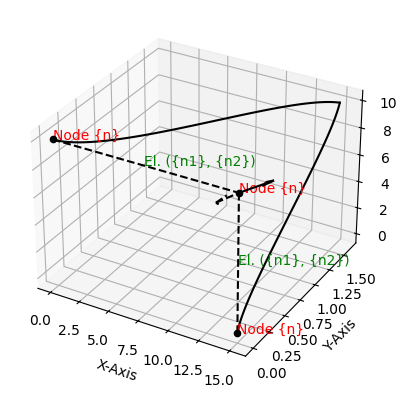

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
mesh.plot(ax)
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_zlabel('Z-Axis')
plt.show()

# Example 2